# Importing Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.interpolate

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM,GRU,Dense,Reshape,InputLayer
from tensorflow.keras import Input

# Importing DataBase

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
df_daily = pd.read_csv('/content/drive/My Drive/ML Projects/Pharma Sales/Data/salesdaily.csv')

# Importing Pre-Treined models

In [4]:
gru_mrf = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_MostRelavantFeatures.h5') #time_step = 30
gru_mrf_wm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_MostRelavantFeatures_weekdayMonth.h5')#time_step = 120
gru = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_OneFeature.h5')#time_step = 30
gru_wm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_weekdayMonth.h5')#time_step = 120
gru_wm_cylic = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_weekdayMonth_cyclic.h5')#time_step = 120

In [5]:
lstm_mrf_wm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/LSTM Models/LSTM_multiFeature_mostRelevantFeatures_weekdayMonth.h5')#time_step = 60
lstm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/LSTM Models/LSTM_oneFeature.h5')#time_step = 30
lstm_wm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/LSTM Models/LSTM_multiFeature_weekdayMonth.h5')#time_step = 60

#Functions

In [6]:
def dataSplit(df,train_percent,val_percent):
  train_limit = int(round((df.shape[0])*train_percent,0))
  val_limit = int(round((df.shape[0])*(train_percent+val_percent),0))
  
  df_train = df[:train_limit]
  df_val = df[train_limit:val_limit]
  df_test = df[val_limit:]

  print(df_train.shape)
  print(df_val.shape)
  print(df_test.shape)

  return df_train,df_val,df_test

In [7]:
def normalizing_data(df_train,df_val,df_test,frange):
  sc = MinMaxScaler(feature_range = frange)
  try:
    aux = df_train.shape[1]
    df_train_norm = sc.fit_transform(df_train)
    df_val_norm = sc.transform(df_val)
    df_test_norm = sc.transform(df_test)

  except:
    df_train = df_train.values.reshape(-1,1)
    df_val = df_val.values.reshape(-1,1)
    df_test = df_test.values.reshape(-1,1)

    
    df_train_norm = sc.fit_transform(df_train)
    df_val_norm = sc.transform(df_val)
    df_test_norm = sc.transform(df_test)

  print(df_train_norm.max(axis=0))
  print(df_train_norm.min(axis=0))
  print('\n')

  print(df_val_norm.max(axis=0))
  print(df_val_norm.min(axis=0))
  print('\n')

  print(df_test_norm.max(axis=0))
  print(df_test_norm.min(axis=0))

  print('-------------------------')

  print(df_train_norm.shape)
  print(df_val_norm.shape)
  print(df_test_norm.shape)
  return df_train_norm,df_val_norm,df_test_norm

In [8]:
def Regressor(future_steps,time_steps,n_features,df_train,df_val,df_test):
  # future_steps: how many days in the furure to predict 
  # time_steps: number of samples the LSTM model will use for predict 28 days in the future
  # n_features: number of features (LSTM input) 

  #################### TRAIN #################################################
  # Defining the number of samples for the train data
  n_samples = df_train.shape[0]
  x_train = []
  y_train = []

  # shaping data to have the number of time_steps in the x_train ans the 28 future values in the y_train 
  for i in range(time_steps,n_samples - future_steps): 
    x_train.append(df_train[i - time_steps : i, :]) 
    y_train.append(df_train[i : i + future_steps, -1 ]) 

  x_train,y_train = np.array(x_train),np.array(y_train) # transforming in array
  # LSTM need 3D tensor as input 
  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],n_features))  

  ##################### VALIDATION ###############################################

  df_val = np.concatenate((df_train[-time_steps:],df_val))

  n_samples = df_val.shape[0]
  x_val = []
  y_val = []

  for i in range(time_steps,n_samples - future_steps):
    x_val.append(df_val[i - time_steps : i, :]) 
    y_val.append(df_val[i : i + future_steps,-1]) 

  x_val,y_val = np.array(x_val),np.array(y_val)
  x_val = np.reshape(x_val,(x_val.shape[0],x_val.shape[1],n_features))

  ####################### TEST ################################################

  df_test = np.concatenate((df_val[-time_steps:],df_test))
  n_samples = df_test.shape[0]
  x_test = []
  y_test = []

  for i in range(time_steps,n_samples - future_steps):
    x_test.append(df_test[i - time_steps : i, :]) 
    y_test.append(df_test[i : i + future_steps,-1]) 

  x_test,y_test = np.array(x_test),np.array(y_test)
  x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],n_features))

  x_train = x_train.astype(np.float32)
  y_train = y_train.astype(np.float32)

  x_val = x_val.astype(np.float32)
  y_val = y_val.astype(np.float32)

  x_test = x_test.astype(np.float32)
  y_test = y_test.astype(np.float32)
  
  return x_train,x_test,x_val,y_train,y_val,y_test

# Colaborative predictions

The main idea it's to use multiple RNN predictions to make a better final prediction. 
This notebook will implement exactly the diagram below:  

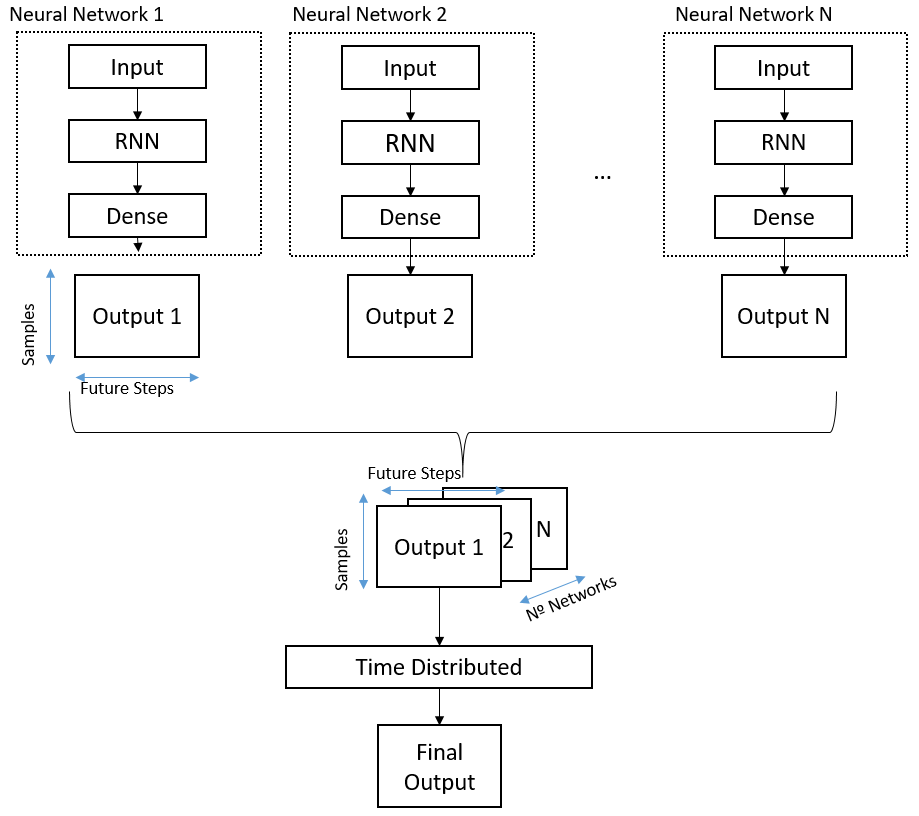

----

The RNN's are pre-treined and have already been imported, the next step it's to prepare the data to create the proposed architecture.


# Data Preparetion

This topic will be divided in two parts:

- Data prep for networks that have been trained with the `same number` of times steps.

- Data prep for networks that have been trained with `differents numbers` of times steps

---

It's important to remember that some networks have been trained with differents types of extra features (they were all trained with the target feature) , so some input maybe differents than others.

## Creating Extra Features

In [9]:
df_daily = df_daily[['datum','Weekday Name','N02BE']]
df_daily.columns = ['data','weekday','N02BE']

df_daily['data'] = pd.to_datetime(df_daily['data'])
df_daily['month'] = df_daily['data'].dt.month
df_daily = df_daily[['weekday','month','N02BE']]

df_daily = pd.concat([pd.get_dummies(df_daily['weekday']),df_daily],axis=1)
dict_ = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
df_daily['weekday'].replace(dict_,inplace = True)

df_daily = pd.concat([pd.get_dummies(df_daily['month']),df_daily],axis=1)

df_daily['weekday_sin'] = np.sin(df_daily['weekday']*(2.*np.pi/24))
df_daily['weekday_cos'] = np.cos(df_daily['weekday']*(2.*np.pi/24))
df_daily['month_sin'] = np.sin((df_daily['month']-1)*(2.*np.pi/12))
df_daily['month_cos'] = np.cos((df_daily['month']-1)*(2.*np.pi/12))

df_daily['lag1'] = df_daily['N02BE'].shift(1)
df_daily['lag2'] = df_daily['N02BE'].shift(2)
df_daily['lag3'] = df_daily['N02BE'].shift(3)
df_daily['lag4'] = df_daily['N02BE'].shift(4)
df_daily['lag5'] = df_daily['N02BE'].shift(5)
df_daily['lag6'] = df_daily['N02BE'].shift(6)
df_daily['lag7'] = df_daily['N02BE'].shift(7)
df_daily['lag30'] = df_daily['N02BE'].shift(30)
df_daily['lag60'] = df_daily['N02BE'].shift(60)
df_daily['lag120'] = df_daily['N02BE'].shift(120)
df_daily['lag240'] = df_daily['N02BE'].shift(240)

df_daily['rolling_mean_2'] = df_daily['N02BE'].rolling(window = 2).mean()
df_daily['rolling_mean_3'] = df_daily['N02BE'].rolling(window = 3).mean()
df_daily['rolling_mean_4'] = df_daily['N02BE'].rolling(window = 4).mean()
df_daily['rolling_mean_5'] = df_daily['N02BE'].rolling(window = 5).mean()
df_daily['rolling_mean_6'] = df_daily['N02BE'].rolling(window = 6).mean()
df_daily['rolling_mean_7'] = df_daily['N02BE'].rolling(window = 7).mean()
df_daily['rolling_mean_30'] = df_daily['N02BE'].rolling(window = 30).mean()
df_daily['rolling_mean_60'] = df_daily['N02BE'].rolling(window = 60).mean()
df_daily['rolling_mean_120'] = df_daily['N02BE'].rolling(window = 120).mean()
df_daily['rolling_mean_240'] = df_daily['N02BE'].rolling(window = 240).mean()

df_daily = df_daily[['weekday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','weekday_sin','weekday_cos','month',1,2,3,4,5,6,7,8,9,10,11,12,'month_sin','month_cos',
          'lag1','lag2','lag3','lag4','lag5','lag6','lag7','lag30','lag60','lag120','lag240',
          'rolling_mean_2','rolling_mean_3','rolling_mean_4','rolling_mean_5','rolling_mean_6','rolling_mean_7','rolling_mean_30','rolling_mean_60','rolling_mean_120','rolling_mean_240',
          'N02BE']]

df_daily.fillna(0,inplace = True)

df_daily.head()

,weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday_sin,weekday_cos,month,1,2,3,4,5,6,7,8,9,10,11,12,month_sin,month_cos,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag30,lag60,lag120,lag240,rolling_mean_2,rolling_mean_3,rolling_mean_4,rolling_mean_5,rolling_mean_6,rolling_mean_7,rolling_mean_30,rolling_mean_60,rolling_mean_120,rolling_mean_240,N02BE
0,4,0,0,0,1,0,0,0,0.866025,5.000000e-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,32.40
1,5,0,0,0,0,1,0,0,0.965926,2.588190e-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,32.40,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.500,0.000000,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,50.60
2,6,0,0,0,0,0,1,0,1.000000,6.123234e-17,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,50.60,32.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.225,48.283333,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,61.85
3,7,0,0,0,0,0,0,1,0.965926,-2.588190e-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,61.85,50.60,32.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.475,51.183333,46.4875,0.00,0.0,0.0,0.0,0.0,0.0,0.0,41.10
4,1,1,0,0,0,0,0,0,0.258819,9.659258e-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,41.10,61.85,50.6,32.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.400,41.550000,43.8125,41.53,0.0,0.0,0.0,0.0,0.0,0.0,21.70


# Same number of times steps 

30 times steps:
- gru_mrf
- gru
- lstm

60 times steps:
- lstm_mrf_wm
- lstm_wm

120 times steps:
- gru_mrf_wm
- gru_wm
- gru_wm_cylic


# Training from Outputs



## 30 Times Steps

- gru_mrf

In [ ]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['lag1','rolling_mean_2','rolling_mean_3','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_gru_mrf,val_gru_mrf,test_gru_mrf = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 4)
(316, 4)
(316, 4)
[1. 1. 1. 1.]
[0. 0. 0. 0.]


[0.46335404 0.51821283 0.54192647 0.46335404]
[0.         0.07067853 0.08834426 0.        ]


[0.62173913 0.73377827 0.69222001 0.62173913]
[0.         0.05005562 0.09119407 0.        ]
-------------------------
(1474, 4)
(316, 4)
(316, 4)


In [ ]:
# Regressor
time_steps = 30
future_steps = 5
n_features = train_gru_mrf.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_gru_mrf,df_val = val_gru_mrf,df_test = test_gru_mrf)

# Prediction
x_train_gru_mrf = gru_mrf.predict(x_train)
x_val_gru_mrf = gru_mrf.predict(x_val)
x_test_gru_mrf = gru_mrf.predict(x_test)

In [ ]:
x_train_gru_mrf.shape

(1439, 5)

- gru

In [ ]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily['N02BE'],train_percent = 0.7,val_percent = 0.15)
train_gru,val_gru,test_gru = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474,)
(316,)
(316,)
[1.]
[0.]


[0.46335404]
[0.]


[0.62173913]
[0.]
-------------------------
(1474, 1)
(316, 1)
(316, 1)


In [ ]:
# Regressor
time_steps = 30
future_steps = 5
n_features = train_gru.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_gru,df_val = val_gru,df_test = test_gru)

# Prediction
x_train_gru = gru.predict(x_train)
x_val_gru = gru.predict(x_val)
x_test_gru = gru.predict(x_test)

- lstm

In [ ]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily['N02BE'],train_percent = 0.7,val_percent = 0.15)
train_lstm,val_lstm,test_lstm = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474,)
(316,)
(316,)
[1.]
[0.]


[0.46335404]
[0.]


[0.62173913]
[0.]
-------------------------
(1474, 1)
(316, 1)
(316, 1)


In [ ]:
# Regressor
time_steps = 30
future_steps = 5
n_features = train_lstm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_lstm,df_val = val_lstm,df_test = test_lstm)

# Prediction
x_train_lstm = lstm.predict(x_train)
x_val_lstm = lstm.predict(x_val)
x_test_lstm = lstm.predict(x_test)

### Reshaping data
 
The outputs predictions from the previous networks will be reshaped according to the figure below  

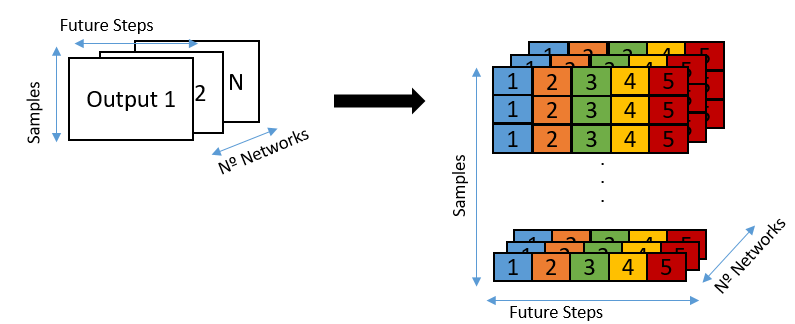


Creating 3D matriz from networks outputs

In [ ]:
x_train = np.array([    x_train_gru_mrf, x_train_gru, x_train_lstm     ])
x_val = np.array([    x_val_gru_mrf, x_val_gru, x_val_lstm     ])
x_test = np.array([    x_test_gru_mrf, x_test_gru, x_test_lstm     ])

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print('\n')
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3, 1439, 5)
(3, 311, 5)
(3, 311, 5)


(1439, 5)
(311, 5)
(311, 5)



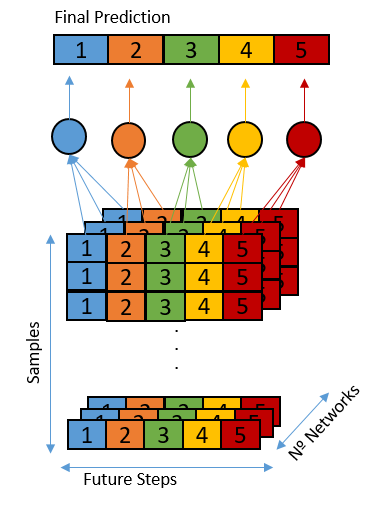

### Creating Model

In [ ]:
input_1 = Input(shape=(x_train.shape[0],))
input_2 = Input(shape=(x_train.shape[0],))
input_3 = Input(shape=(x_train.shape[0],))
input_4 = Input(shape=(x_train.shape[0],))
input_5 = Input(shape=(x_train.shape[0],))


output_1 = Dense(1,activation='linear')(input_1)
output_2 = Dense(1,activation='linear')(input_2)
output_3 = Dense(1,activation='linear')(input_3)
output_4 = Dense(1,activation='linear')(input_4)
output_5 = Dense(1,activation='linear')(input_5)

model = Model( inputs = [input_1,input_2,input_3,input_4,input_5], outputs = [output_1,output_2,output_3,output_4,output_5] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3)]          0                                            
______________________________________________________________________________________________

In [ ]:
#train
input_1_train = x_train[:,:,0].T
input_2_train = x_train[:,:,1].T
input_3_train = x_train[:,:,2].T
input_4_train = x_train[:,:,3].T
input_5_train = x_train[:,:,4].T

output_1_train = y_train[:,0]
output_2_train = y_train[:,1]
output_3_train = y_train[:,2]
output_4_train = y_train[:,3]
output_5_train = y_train[:,4]

#val
input_1_val = x_val[:,:,0].T
input_2_val = x_val[:,:,1].T
input_3_val = x_val[:,:,2].T
input_4_val = x_val[:,:,3].T
input_5_val = x_val[:,:,4].T

output_1_val = y_val[:,0]
output_2_val = y_val[:,1]
output_3_val = y_val[:,2]
output_4_val = y_val[:,3]
output_5_val = y_val[:,4]

#test
input_1_test = x_test[:,:,0].T
input_2_test = x_test[:,:,1].T
input_3_test = x_test[:,:,2].T
input_4_test = x_test[:,:,3].T
input_5_test = x_test[:,:,4].T

output_1_test = y_test[:,0]
output_2_test = y_test[:,1]
output_3_test = y_test[:,2]
output_4_test = y_test[:,3]
output_5_test = y_test[:,4]


### Final Dense Layer

This layer will recive the prediction from the others network and make a final prediction.

- Trainig Model

In [ ]:
model.compile(optimizer='adam',metrics=['mae'],loss='mse')
history = model.fit( [ input_1_train,input_2_train,input_3_train,input_4_train,input_5_train ], [ output_1_train,output_2_train,output_3_train,output_4_train,output_5_train ],
                    # validation_data=[ [ input_1_val,input_2_val,input_3_val,input_4_val,input_5_val ] , [ output_1_val,output_2_val,output_3_val,output_4_val,output_5_val ] ] ,
                    epochs=500,batch_size=32,verbose=0)

In [ ]:
history.history.keys()

dict_keys(['loss', 'dense_loss', 'dense_1_loss', 'dense_2_loss', 'dense_3_loss', 'dense_4_loss', 'dense_mae', 'dense_1_mae', 'dense_2_mae', 'dense_3_mae', 'dense_4_mae'])

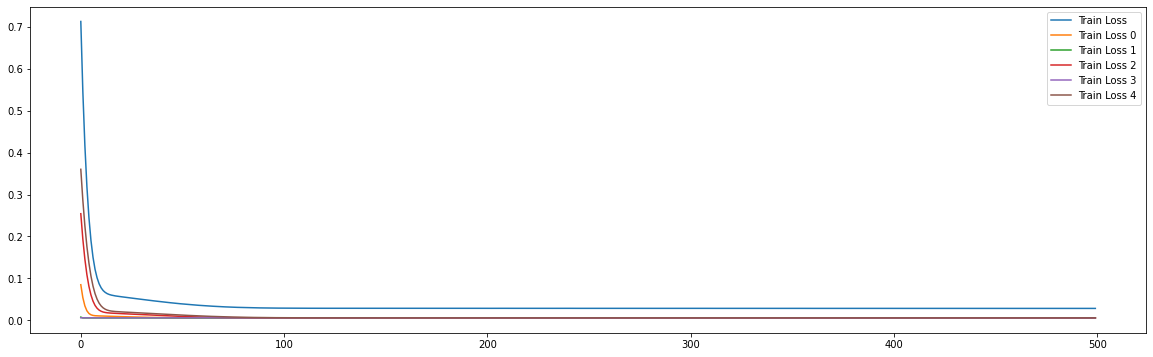

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['dense_loss'])
plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['dense_2_loss'])
plt.plot(history.history['dense_3_loss'])
plt.plot(history.history['dense_4_loss'])
plt.legend([
            'Train Loss',
            'Train Loss 0',
            'Train Loss 1',
            'Train Loss 2',
            'Train Loss 3',
            'Train Loss 4' 
            ])

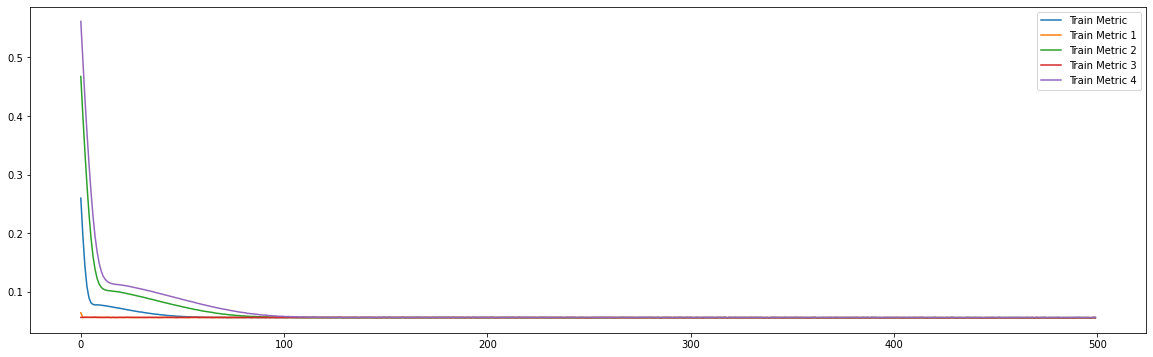

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(history.history['dense_mae'])
plt.plot(history.history['dense_1_mae'])
plt.plot(history.history['dense_2_mae'])
plt.plot(history.history['dense_3_mae'])
plt.plot(history.history['dense_4_mae'])
plt.legend(['Train Metric', 'Train Metric 1','Train Metric 2','Train Metric 3','Train Metric 4'])

### Evaluating

In [ ]:
model.evaluate([ input_1_train,input_2_train,input_3_train,input_4_train,input_5_train ], [ output_1_train,output_2_train,output_3_train,output_4_train,output_5_train ])

45/45 [==============================] - 0s 3ms/step - loss: 0.0283 - dense_loss: 0.0056 - dense_1_loss: 0.0055 - dense_2_loss: 0.0056 - dense_3_loss: 0.0057 - dense_4_loss: 0.0058 - dense_mae: 0.0557 - dense_1_mae: 0.0558 - dense_2_mae: 0.0565 - dense_3_mae: 0.0557 - dense_4_mae: 0.0559


[0.028326349332928658,
 0.005626255646348,
 0.005540987942367792,
 0.005626498721539974,
 0.005691315047442913,
 0.005841292440891266,
 0.05565186217427254,
 0.05576975643634796,
 0.05652598291635513,
 0.05565722659230232,
 0.05588040128350258]

In [ ]:
model.evaluate([ input_1_val,input_2_val,input_3_val,input_4_val,input_5_val ] , [ output_1_val,output_2_val,output_3_val,output_4_val,output_5_val ])

10/10 [==============================] - 0s 4ms/step - loss: 0.0241 - dense_loss: 0.0047 - dense_1_loss: 0.0050 - dense_2_loss: 0.0049 - dense_3_loss: 0.0048 - dense_4_loss: 0.0048 - dense_mae: 0.0538 - dense_1_mae: 0.0552 - dense_2_mae: 0.0557 - dense_3_mae: 0.0548 - dense_4_mae: 0.0550


[0.024076029658317566,
 0.004667456727474928,
 0.00499908160418272,
 0.004857215099036694,
 0.004754279274493456,
 0.004797995090484619,
 0.053811486810445786,
 0.05520283430814743,
 0.0557183213531971,
 0.054834943264722824,
 0.05504295974969864]

In [ ]:
model.evaluate([ input_1_test,input_2_test,input_3_test,input_4_test,input_5_test ] , [ output_1_test,output_2_test,output_3_test,output_4_test,output_5_test ])

10/10 [==============================] - 0s 3ms/step - loss: 0.0338 - dense_loss: 0.0060 - dense_1_loss: 0.0077 - dense_2_loss: 0.0072 - dense_3_loss: 0.0065 - dense_4_loss: 0.0063 - dense_mae: 0.0567 - dense_1_mae: 0.0604 - dense_2_mae: 0.0606 - dense_3_mae: 0.0591 - dense_4_mae: 0.0592


[0.03375973924994469,
 0.0060396138578653336,
 0.007745378650724888,
 0.007206988055258989,
 0.006506862584501505,
 0.006260898895561695,
 0.056660208851099014,
 0.06036585941910744,
 0.06063607335090637,
 0.059142932295799255,
 0.05915927141904831]

## 60 Times steps

- lstm_mrf_wm

In [ ]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['weekday','month','lag1','rolling_mean_2','rolling_mean_3','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_lstm_mrf_wm,val_lstm_mrf_wm,test_lstm_mrf_wm = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 6)
(316, 6)
(316, 6)
[1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0.]


[1.         0.90909091 0.46335404 0.51821283 0.54192647 0.46335404]
[0.         0.         0.         0.07067853 0.08834426 0.        ]


[1.         1.         0.62173913 0.73377827 0.69222001 0.62173913]
[0.         0.         0.         0.05005562 0.09119407 0.        ]
-------------------------
(1474, 6)
(316, 6)
(316, 6)


In [ ]:
# Regressor
time_steps = 60
future_steps = 5
n_features = train_lstm_mrf_wm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_lstm_mrf_wm,df_val = val_lstm_mrf_wm,df_test = test_lstm_mrf_wm)

# Prediction
x_train_lstm_mrf_wm = lstm_mrf_wm.predict(x_train)
x_val_lstm_mrf_wm = lstm_mrf_wm.predict(x_val)
x_test_lstm_mrf_wm = lstm_mrf_wm.predict(x_test)

In [ ]:
x_train_lstm_mrf_wm.shape

(1409, 5)

- lstm_wm

In [ ]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['weekday','month','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_lstm_wm,val_lstm_wm,test_lstm_wm = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 3)
(316, 3)
(316, 3)
[1. 1. 1.]
[0. 0. 0.]


[1.         0.90909091 0.46335404]
[0. 0. 0.]


[1.         1.         0.62173913]
[0. 0. 0.]
-------------------------
(1474, 3)
(316, 3)
(316, 3)


In [ ]:
# Regressor
time_steps = 60
future_steps = 5
n_features = train_lstm_wm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_lstm_wm,df_val = val_lstm_wm,df_test = test_lstm_wm)

# Prediction
x_train_lstm_wm = lstm_wm.predict(x_train)
x_val_lstm_wm = lstm_wm.predict(x_val)
x_test_lstm_wm = lstm_wm.predict(x_test)

In [ ]:
x_train_lstm_wm.shape

(1409, 5)

### Reshaping

In [ ]:
x_train = np.array([    x_train_lstm_mrf_wm, x_train_lstm_wm    ])
x_val = np.array([    x_val_lstm_mrf_wm, x_val_lstm_wm    ])
x_test = np.array([    x_test_lstm_mrf_wm, x_test_lstm_wm     ])

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print('\n')
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2, 1409, 5)
(2, 311, 5)
(2, 311, 5)


(1409, 5)
(311, 5)
(311, 5)



### Creating Model

In [ ]:
input_1 = Input(shape=(x_train.shape[0],))
input_2 = Input(shape=(x_train.shape[0],))
input_3 = Input(shape=(x_train.shape[0],))
input_4 = Input(shape=(x_train.shape[0],))
input_5 = Input(shape=(x_train.shape[0],))


output_1 = Dense(1,activation='linear')(input_1)
output_2 = Dense(1,activation='linear')(input_2)
output_3 = Dense(1,activation='linear')(input_3)
output_4 = Dense(1,activation='linear')(input_4)
output_5 = Dense(1,activation='linear')(input_5)

model = Model( inputs = [input_1,input_2,input_3,input_4,input_5], outputs = [output_1,output_2,output_3,output_4,output_5] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0                                            
______________________________________________________________________________________________

In [ ]:
#train
input_1_train = x_train[:,:,0].T
input_2_train = x_train[:,:,1].T
input_3_train = x_train[:,:,2].T
input_4_train = x_train[:,:,3].T
input_5_train = x_train[:,:,4].T

output_1_train = y_train[:,0]
output_2_train = y_train[:,1]
output_3_train = y_train[:,2]
output_4_train = y_train[:,3]
output_5_train = y_train[:,4]

#val
input_1_val = x_val[:,:,0].T
input_2_val = x_val[:,:,1].T
input_3_val = x_val[:,:,2].T
input_4_val = x_val[:,:,3].T
input_5_val = x_val[:,:,4].T

output_1_val = y_val[:,0]
output_2_val = y_val[:,1]
output_3_val = y_val[:,2]
output_4_val = y_val[:,3]
output_5_val = y_val[:,4]

#test
input_1_test = x_test[:,:,0].T
input_2_test = x_test[:,:,1].T
input_3_test = x_test[:,:,2].T
input_4_test = x_test[:,:,3].T
input_5_test = x_test[:,:,4].T

output_1_test = y_test[:,0]
output_2_test = y_test[:,1]
output_3_test = y_test[:,2]
output_4_test = y_test[:,3]
output_5_test = y_test[:,4]

### Final Dense Layer

- Trainig Model

In [ ]:
model.compile(optimizer='adam',metrics=['mae'],loss='mse')
history = model.fit( [ input_1_train,input_2_train,input_3_train,input_4_train,input_5_train ], [ output_1_train,output_2_train,output_3_train,output_4_train,output_5_train ],
                    epochs=500,batch_size=32,verbose=0)

In [ ]:
history.history.keys()

dict_keys(['loss', 'dense_loss', 'dense_1_loss', 'dense_2_loss', 'dense_3_loss', 'dense_4_loss', 'dense_mae', 'dense_1_mae', 'dense_2_mae', 'dense_3_mae', 'dense_4_mae'])

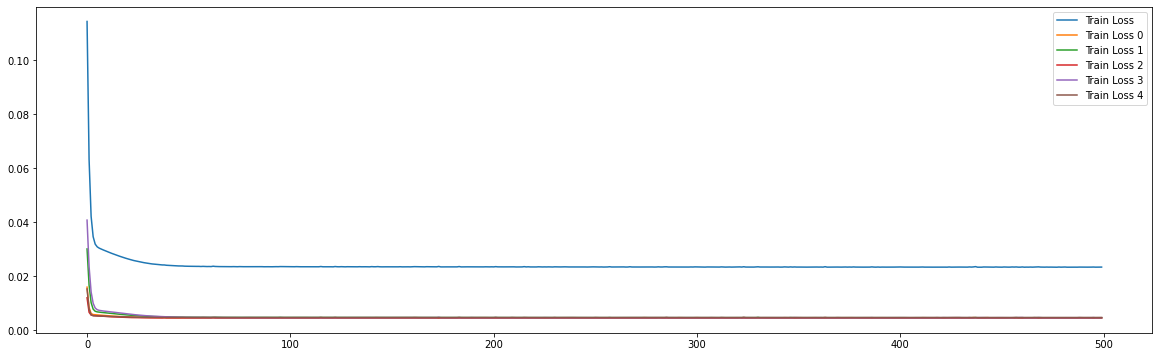

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['dense_loss'])
plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['dense_2_loss'])
plt.plot(history.history['dense_3_loss'])
plt.plot(history.history['dense_4_loss'])
plt.legend([
            'Train Loss',
            'Train Loss 0',
            'Train Loss 1',
            'Train Loss 2',
            'Train Loss 3',
            'Train Loss 4' 
            ])

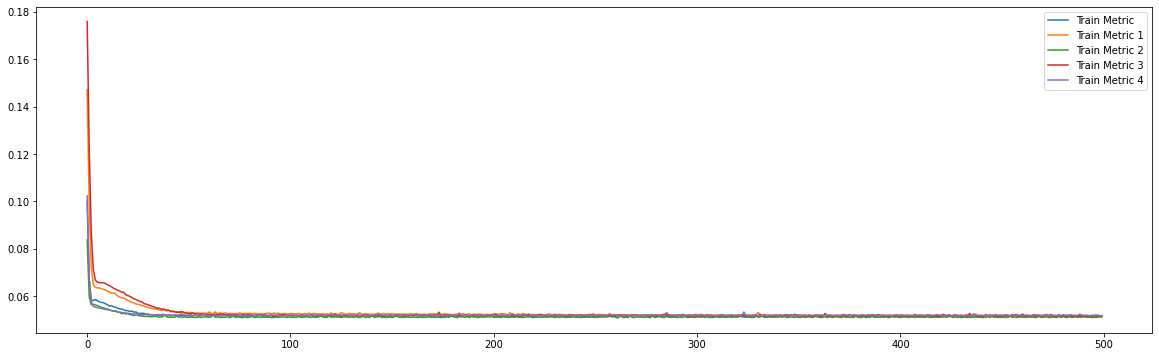

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(history.history['dense_mae'])
plt.plot(history.history['dense_1_mae'])
plt.plot(history.history['dense_2_mae'])
plt.plot(history.history['dense_3_mae'])
plt.plot(history.history['dense_4_mae'])
plt.legend(['Train Metric', 'Train Metric 1','Train Metric 2','Train Metric 3','Train Metric 4'])

### Evaluating

In [ ]:
model.evaluate([ input_1_train,input_2_train,input_3_train,input_4_train,input_5_train ], [ output_1_train,output_2_train,output_3_train,output_4_train,output_5_train ])

45/45 [==============================] - 0s 4ms/step - loss: 0.0233 - dense_loss: 0.0047 - dense_1_loss: 0.0047 - dense_2_loss: 0.0046 - dense_3_loss: 0.0047 - dense_4_loss: 0.0047 - dense_mae: 0.0519 - dense_1_mae: 0.0518 - dense_2_mae: 0.0513 - dense_3_mae: 0.0520 - dense_4_mae: 0.0519


[0.023345809429883957,
 0.004668029490858316,
 0.004666056018322706,
 0.0045866877771914005,
 0.004681660793721676,
 0.004743379540741444,
 0.05192594975233078,
 0.051776666194200516,
 0.05127899721264839,
 0.05196257308125496,
 0.05194000154733658]

In [ ]:
model.evaluate([ input_1_val,input_2_val,input_3_val,input_4_val,input_5_val ] , [ output_1_val,output_2_val,output_3_val,output_4_val,output_5_val ])

10/10 [==============================] - 0s 3ms/step - loss: 0.0244 - dense_loss: 0.0048 - dense_1_loss: 0.0050 - dense_2_loss: 0.0047 - dense_3_loss: 0.0049 - dense_4_loss: 0.0050 - dense_mae: 0.0535 - dense_1_mae: 0.0540 - dense_2_mae: 0.0529 - dense_3_mae: 0.0538 - dense_4_mae: 0.0541


[0.02439309097826481,
 0.0048341029323637486,
 0.004954168107360601,
 0.0047400519251823425,
 0.004880464635789394,
 0.00498430198058486,
 0.053526852279901505,
 0.05397256836295128,
 0.052867624908685684,
 0.05382790043950081,
 0.05409333482384682]

In [ ]:
model.evaluate([ input_1_test,input_2_test,input_3_test,input_4_test,input_5_test ] , [ output_1_test,output_2_test,output_3_test,output_4_test,output_5_test ])

10/10 [==============================] - 0s 3ms/step - loss: 0.0313 - dense_loss: 0.0058 - dense_1_loss: 0.0061 - dense_2_loss: 0.0062 - dense_3_loss: 0.0065 - dense_4_loss: 0.0066 - dense_mae: 0.0575 - dense_1_mae: 0.0588 - dense_2_mae: 0.0591 - dense_3_mae: 0.0602 - dense_4_mae: 0.0602


[0.03131562098860741,
 0.005789261311292648,
 0.0061285290867090225,
 0.006229763384908438,
 0.006526411976665258,
 0.006641657557338476,
 0.05751675367355347,
 0.05878639966249466,
 0.059146929532289505,
 0.060228876769542694,
 0.06021348759531975]

## 120 Times Steps

- gru_mrf_wm

In [ ]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['weekday','month','lag1','rolling_mean_2','rolling_mean_3','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_gru_mrf_wm,val_gru_mrf_wm,test_gru_mrf_wm = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 6)
(316, 6)
(316, 6)
[1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0.]


[1.         0.90909091 0.46335404 0.51821283 0.54192647 0.46335404]
[0.         0.         0.         0.07067853 0.08834426 0.        ]


[1.         1.         0.62173913 0.73377827 0.69222001 0.62173913]
[0.         0.         0.         0.05005562 0.09119407 0.        ]
-------------------------
(1474, 6)
(316, 6)
(316, 6)


In [ ]:
# Regressor
time_steps = 120
future_steps = 5
n_features = train_gru_mrf_wm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_gru_mrf_wm,df_val = val_gru_mrf_wm,df_test = test_gru_mrf_wm)

# Prediction
x_train_gru_mrf_wm = gru_mrf_wm.predict(x_train)
x_val_gru_mrf_wm = gru_mrf_wm.predict(x_val)
x_test_gru_mrf_wm = gru_mrf_wm.predict(x_test)

- gru_wm

In [ ]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['weekday','month','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_gru_wm,val_gru_wm,test_gru_wm = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 3)
(316, 3)
(316, 3)
[1. 1. 1.]
[0. 0. 0.]


[1.         0.90909091 0.46335404]
[0. 0. 0.]


[1.         1.         0.62173913]
[0. 0. 0.]
-------------------------
(1474, 3)
(316, 3)
(316, 3)


In [ ]:
# Regressor
time_steps = 120
future_steps = 5
n_features = train_gru_wm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_gru_wm,df_val = val_gru_wm,df_test = test_gru_wm)

# Prediction
x_train_gru_wm = gru_wm.predict(x_train)
x_val_gru_wm = gru_wm.predict(x_val)
x_test_gru_wm = gru_wm.predict(x_test)

- gru_wm_cylic

In [ ]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['weekday_sin','weekday_cos','month_sin','month_cos','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_gru_wm_cylic,val_gru_wm_cylic,test_gru_wm_cylic = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 5)
(316, 5)
(316, 5)
[1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0.]


[1.         1.         1.         1.         0.46335404]
[0. 0. 0. 0. 0.]


[1.         1.         1.         1.         0.62173913]
[0. 0. 0. 0. 0.]
-------------------------
(1474, 5)
(316, 5)
(316, 5)


In [ ]:
# Regressor
time_steps = 120
future_steps = 5
n_features = train_gru_wm_cylic.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_gru_wm_cylic,df_val = val_gru_wm_cylic,df_test = test_gru_wm_cylic)

# Prediction
x_train_gru_wm_cylic = gru_wm_cylic.predict(x_train)
x_val_gru_wm_cylic = gru_wm_cylic.predict(x_val)
x_test_gru_wm_cylic = gru_wm_cylic.predict(x_test)

### Reshaping

In [ ]:
x_train = np.array([    x_train_gru_mrf_wm, x_train_gru_wm, x_train_gru_wm_cylic   ])
x_val = np.array([    x_val_gru_mrf_wm, x_val_gru_wm, x_val_gru_wm_cylic    ])
x_test = np.array([    x_test_gru_mrf_wm, x_test_gru_wm, x_test_gru_wm_cylic     ])

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print('\n')
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3, 1349, 5)
(3, 311, 5)
(3, 311, 5)


(1349, 5)
(311, 5)
(311, 5)


### Creating Model

In [ ]:
input_1 = Input(shape=(x_train.shape[0],))
input_2 = Input(shape=(x_train.shape[0],))
input_3 = Input(shape=(x_train.shape[0],))
input_4 = Input(shape=(x_train.shape[0],))
input_5 = Input(shape=(x_train.shape[0],))


output_1 = Dense(1,activation='linear')(input_1)
output_2 = Dense(1,activation='linear')(input_2)
output_3 = Dense(1,activation='linear')(input_3)
output_4 = Dense(1,activation='linear')(input_4)
output_5 = Dense(1,activation='linear')(input_5)

model = Model( inputs = [input_1,input_2,input_3,input_4,input_5], outputs = [output_1,output_2,output_3,output_4,output_5] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3)]          0                                            
______________________________________________________________________________________________

In [ ]:
#train
input_1_train = x_train[:,:,0].T
input_2_train = x_train[:,:,1].T
input_3_train = x_train[:,:,2].T
input_4_train = x_train[:,:,3].T
input_5_train = x_train[:,:,4].T

output_1_train = y_train[:,0]
output_2_train = y_train[:,1]
output_3_train = y_train[:,2]
output_4_train = y_train[:,3]
output_5_train = y_train[:,4]

#val
input_1_val = x_val[:,:,0].T
input_2_val = x_val[:,:,1].T
input_3_val = x_val[:,:,2].T
input_4_val = x_val[:,:,3].T
input_5_val = x_val[:,:,4].T

output_1_val = y_val[:,0]
output_2_val = y_val[:,1]
output_3_val = y_val[:,2]
output_4_val = y_val[:,3]
output_5_val = y_val[:,4]

#test
input_1_test = x_test[:,:,0].T
input_2_test = x_test[:,:,1].T
input_3_test = x_test[:,:,2].T
input_4_test = x_test[:,:,3].T
input_5_test = x_test[:,:,4].T

output_1_test = y_test[:,0]
output_2_test = y_test[:,1]
output_3_test = y_test[:,2]
output_4_test = y_test[:,3]
output_5_test = y_test[:,4]

### Final Dense Layer

- Trainig Model

In [ ]:
model.compile(optimizer='adam',metrics=['mae'],loss='mse')
history = model.fit( [ input_1_train,input_2_train,input_3_train,input_4_train,input_5_train ], [ output_1_train,output_2_train,output_3_train,output_4_train,output_5_train ],
                    epochs=500,batch_size=32,verbose=0)

In [ ]:
history.history.keys()

dict_keys(['loss', 'dense_loss', 'dense_1_loss', 'dense_2_loss', 'dense_3_loss', 'dense_4_loss', 'dense_mae', 'dense_1_mae', 'dense_2_mae', 'dense_3_mae', 'dense_4_mae'])

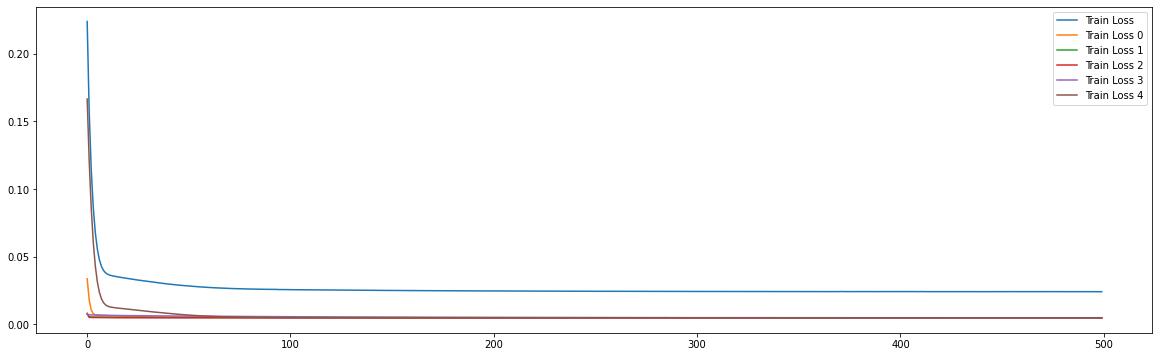

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['dense_loss'])
plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['dense_2_loss'])
plt.plot(history.history['dense_3_loss'])
plt.plot(history.history['dense_4_loss'])
plt.legend([
            'Train Loss',
            'Train Loss 0',
            'Train Loss 1',
            'Train Loss 2',
            'Train Loss 3',
            'Train Loss 4' 
            ])

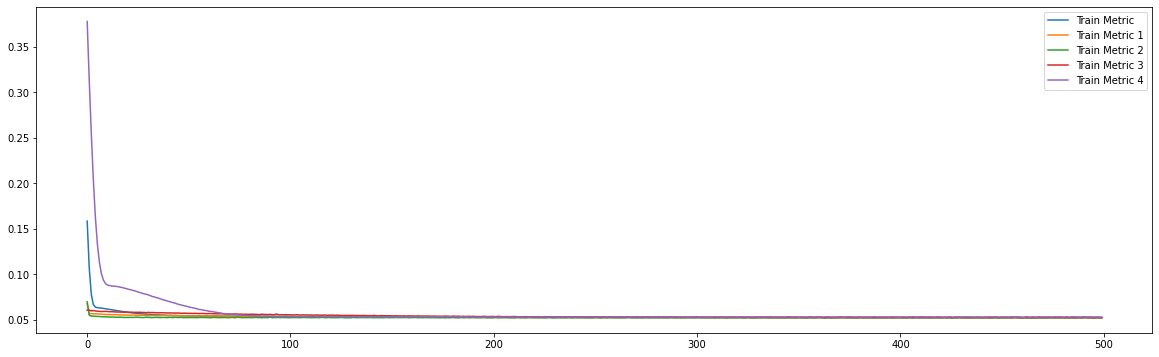

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(history.history['dense_mae'])
plt.plot(history.history['dense_1_mae'])
plt.plot(history.history['dense_2_mae'])
plt.plot(history.history['dense_3_mae'])
plt.plot(history.history['dense_4_mae'])
plt.legend(['Train Metric', 'Train Metric 1','Train Metric 2','Train Metric 3','Train Metric 4'])

### Evaluating

In [ ]:
model.evaluate([ input_1_train,input_2_train,input_3_train,input_4_train,input_5_train ], [ output_1_train,output_2_train,output_3_train,output_4_train,output_5_train ])

43/43 [==============================] - 0s 4ms/step - loss: 0.0242 - dense_loss: 0.0048 - dense_1_loss: 0.0048 - dense_2_loss: 0.0048 - dense_3_loss: 0.0049 - dense_4_loss: 0.0050 - dense_mae: 0.0522 - dense_1_mae: 0.0525 - dense_2_mae: 0.0523 - dense_3_mae: 0.0530 - dense_4_mae: 0.0533


[0.024190273135900497,
 0.004783937241882086,
 0.004799850285053253,
 0.004765908233821392,
 0.00487692141905427,
 0.004963655024766922,
 0.05222194269299507,
 0.05247583985328674,
 0.05227582901716232,
 0.05296934396028519,
 0.05334774777293205]

In [ ]:
model.evaluate([ input_1_val,input_2_val,input_3_val,input_4_val,input_5_val ] , [ output_1_val,output_2_val,output_3_val,output_4_val,output_5_val ])

10/10 [==============================] - 0s 3ms/step - loss: 0.0234 - dense_loss: 0.0046 - dense_1_loss: 0.0046 - dense_2_loss: 0.0047 - dense_3_loss: 0.0047 - dense_4_loss: 0.0048 - dense_mae: 0.0527 - dense_1_mae: 0.0530 - dense_2_mae: 0.0533 - dense_3_mae: 0.0541 - dense_4_mae: 0.0548


[0.023350736126303673,
 0.004645952954888344,
 0.0045897942036390305,
 0.004650171380490065,
 0.004688098095357418,
 0.004776718560606241,
 0.05270072817802429,
 0.052955664694309235,
 0.0533144548535347,
 0.05408323183655739,
 0.05483479052782059]

In [ ]:
model.evaluate([ input_1_test,input_2_test,input_3_test,input_4_test,input_5_test ] , [ output_1_test,output_2_test,output_3_test,output_4_test,output_5_test ])

10/10 [==============================] - 0s 3ms/step - loss: 0.0289 - dense_loss: 0.0056 - dense_1_loss: 0.0055 - dense_2_loss: 0.0058 - dense_3_loss: 0.0060 - dense_4_loss: 0.0060 - dense_mae: 0.0557 - dense_1_mae: 0.0561 - dense_2_mae: 0.0574 - dense_3_mae: 0.0583 - dense_4_mae: 0.0583


[0.028909768909215927,
 0.005551254842430353,
 0.005514863878488541,
 0.005849592387676239,
 0.005957251414656639,
 0.006036806385964155,
 0.05565628036856651,
 0.05608638375997543,
 0.057404857128858566,
 0.05826357752084732,
 0.05833209306001663]

# Multiple Times Steps

## 30 Times Steps

- gru_mrf

In [10]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['lag1','rolling_mean_2','rolling_mean_3','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_gru_mrf,val_gru_mrf,test_gru_mrf = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 4)
(316, 4)
(316, 4)
[1. 1. 1. 1.]
[0. 0. 0. 0.]


[0.46335404 0.51821283 0.54192647 0.46335404]
[0.         0.07067853 0.08834426 0.        ]


[0.62173913 0.73377827 0.69222001 0.62173913]
[0.         0.05005562 0.09119407 0.        ]
-------------------------
(1474, 4)
(316, 4)
(316, 4)


In [11]:
# Regressor
time_steps = 30
future_steps = 5
n_features = train_gru_mrf.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_gru_mrf,df_val = val_gru_mrf,df_test = test_gru_mrf)

# Prediction
x_train_gru_mrf = gru_mrf.predict(x_train)
x_val_gru_mrf = gru_mrf.predict(x_val)
x_test_gru_mrf = gru_mrf.predict(x_test)

In [12]:
x_train_gru_mrf.shape

(1439, 5)

- gru

In [13]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily['N02BE'],train_percent = 0.7,val_percent = 0.15)
train_gru,val_gru,test_gru = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474,)
(316,)
(316,)
[1.]
[0.]


[0.46335404]
[0.]


[0.62173913]
[0.]
-------------------------
(1474, 1)
(316, 1)
(316, 1)


In [14]:
# Regressor
time_steps = 30
future_steps = 5
n_features = train_gru.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_gru,df_val = val_gru,df_test = test_gru)

# Prediction
x_train_gru = gru.predict(x_train)
x_val_gru = gru.predict(x_val)
x_test_gru = gru.predict(x_test)

- lstm

In [15]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily['N02BE'],train_percent = 0.7,val_percent = 0.15)
train_lstm,val_lstm,test_lstm = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474,)
(316,)
(316,)
[1.]
[0.]


[0.46335404]
[0.]


[0.62173913]
[0.]
-------------------------
(1474, 1)
(316, 1)
(316, 1)


In [16]:
# Regressor
time_steps = 30
future_steps = 5
n_features = train_lstm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_lstm,df_val = val_lstm,df_test = test_lstm)

# Prediction
x_train_lstm = lstm.predict(x_train)
x_val_lstm = lstm.predict(x_val)
x_test_lstm = lstm.predict(x_test)

30 times steps final DataFrames

In [29]:
df_train_30 = pd.DataFrame(data = np.concatenate([x_train_gru_mrf,x_train_gru,x_train_lstm],axis=1),
                           columns= ['gru_mrf_1','gru_mrf_2','gru_mrf_3','gru_mrf_4','gru_mrf_5','gru_1',
                                     'gru_2','gru_3','gru_4','gru_5','lstm_1','lstm_2','lstm_3','lstm_4','lstm_5'] )

df_val_30 = pd.DataFrame(data = np.concatenate([x_val_gru_mrf,x_val_gru,x_val_lstm],axis=1),
                           columns= ['gru_mrf_1','gru_mrf_2','gru_mrf_3','gru_mrf_4','gru_mrf_5','gru_1',
                                     'gru_2','gru_3','gru_4','gru_5','lstm_1','lstm_2','lstm_3','lstm_4','lstm_5'] )

df_test_30 = pd.DataFrame(data = np.concatenate([x_test_gru_mrf,x_test_gru,x_test_lstm],axis=1),
                           columns= ['gru_mrf_1','gru_mrf_2','gru_mrf_3','gru_mrf_4','gru_mrf_5','gru_1',
                                     'gru_2','gru_3','gru_4','gru_5','lstm_1','lstm_2','lstm_3','lstm_4','lstm_5'] )

## 60 Times steps

- lstm_mrf_wm

In [30]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['weekday','month','lag1','rolling_mean_2','rolling_mean_3','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_lstm_mrf_wm,val_lstm_mrf_wm,test_lstm_mrf_wm = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 6)
(316, 6)
(316, 6)
[1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0.]


[1.         0.90909091 0.46335404 0.51821283 0.54192647 0.46335404]
[0.         0.         0.         0.07067853 0.08834426 0.        ]


[1.         1.         0.62173913 0.73377827 0.69222001 0.62173913]
[0.         0.         0.         0.05005562 0.09119407 0.        ]
-------------------------
(1474, 6)
(316, 6)
(316, 6)


In [31]:
# Regressor
time_steps = 60
future_steps = 5
n_features = train_lstm_mrf_wm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_lstm_mrf_wm,df_val = val_lstm_mrf_wm,df_test = test_lstm_mrf_wm)

# Prediction
x_train_lstm_mrf_wm = lstm_mrf_wm.predict(x_train)
x_val_lstm_mrf_wm = lstm_mrf_wm.predict(x_val)
x_test_lstm_mrf_wm = lstm_mrf_wm.predict(x_test)

In [32]:
x_train_lstm_mrf_wm.shape

(1409, 5)

- lstm_wm

In [33]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['weekday','month','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_lstm_wm,val_lstm_wm,test_lstm_wm = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 3)
(316, 3)
(316, 3)
[1. 1. 1.]
[0. 0. 0.]


[1.         0.90909091 0.46335404]
[0. 0. 0.]


[1.         1.         0.62173913]
[0. 0. 0.]
-------------------------
(1474, 3)
(316, 3)
(316, 3)


In [34]:
# Regressor
time_steps = 60
future_steps = 5
n_features = train_lstm_wm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_lstm_wm,df_val = val_lstm_wm,df_test = test_lstm_wm)

# Prediction
x_train_lstm_wm = lstm_wm.predict(x_train)
x_val_lstm_wm = lstm_wm.predict(x_val)
x_test_lstm_wm = lstm_wm.predict(x_test)

In [35]:
x_train_lstm_wm.shape

(1409, 5)

60 times steps final DataFrames

In [36]:
df_train_60 = pd.DataFrame(data = np.concatenate([x_train_lstm_mrf_wm,x_train_lstm_wm],axis=1),
                           columns= ['lstm_mrf_wm_1','lstm_mrf_wm_2','lstm_mrf_wm_3','lstm_mrf_wm_4',
                                     'lstm_mrf_wm_5','lstm_wm_1','lstm_wm_2','lstm_wm_3','lstm_wm_4',
                                     'lstm_wm_5'] )

df_val_60 = pd.DataFrame(data = np.concatenate([x_val_lstm_mrf_wm,x_val_lstm_wm],axis=1),
                           columns= ['lstm_mrf_wm_1','lstm_mrf_wm_2','lstm_mrf_wm_3','lstm_mrf_wm_4',
                                     'lstm_mrf_wm_5','lstm_wm_1','lstm_wm_2','lstm_wm_3','lstm_wm_4',
                                     'lstm_wm_5'] )

df_test_60 = pd.DataFrame(data = np.concatenate([x_test_lstm_mrf_wm,x_test_lstm_wm],axis=1),
                           columns= ['lstm_mrf_wm_1','lstm_mrf_wm_2','lstm_mrf_wm_3','lstm_mrf_wm_4',
                                     'lstm_mrf_wm_5','lstm_wm_1','lstm_wm_2','lstm_wm_3','lstm_wm_4',
                                     'lstm_wm_5'] )

## Combining 30 and 60 Times Steps

In [37]:
df_train_60

,lstm_mrf_wm_1,lstm_mrf_wm_2,lstm_mrf_wm_3,lstm_mrf_wm_4,lstm_mrf_wm_5,lstm_wm_1,lstm_wm_2,lstm_wm_3,lstm_wm_4,lstm_wm_5
0,0.237484,0.228174,0.214752,0.207162,0.200110,0.223916,0.227496,0.211687,0.203224,0.191610
1,0.220401,0.210729,0.201294,0.201437,0.201886,0.213581,0.214950,0.200717,0.196804,0.192893
2,0.206264,0.201026,0.198363,0.206565,0.210067,0.206296,0.205292,0.196221,0.202444,0.204589
3,0.196818,0.197321,0.202570,0.212225,0.206541,0.197362,0.200845,0.196389,0.202757,0.198105
4,0.194948,0.201249,0.208906,0.211427,0.196349,0.195017,0.200914,0.197719,0.203487,0.195059
...,...,...,...,...,...,...,...,...,...,...
1404,0.217970,0.224262,0.226318,0.231216,0.219852,0.221806,0.221231,0.205450,0.214223,0.211983
1405,0.210284,0.216448,0.216514,0.223433,0.215414,0.212299,0.215506,0.202561,0.213014,0.205734
1406,0.210279,0.219462,0.220064,0.230880,0.224788,0.212651,0.212292,0.206556,0.230630,0.227439
1407,0.212666,0.226875,0.228475,0.234168,0.220008,0.210924,0.230380,0.225925,0.235607,0.212352


In [38]:
df_train_30

,gru_mrf_1,gru_mrf_2,gru_mrf_3,gru_mrf_4,gru_mrf_5,gru_1,gru_2,gru_3,gru_4,gru_5,lstm_1,lstm_2,lstm_3,lstm_4,lstm_5
0,0.152842,0.149141,0.143549,0.135716,0.132071,0.152800,0.148755,0.138787,0.126661,0.131305,0.151874,0.145950,0.142073,0.132193,0.131133
1,0.157650,0.150340,0.143711,0.146080,0.157057,0.161099,0.158713,0.148660,0.146507,0.162227,0.154016,0.147025,0.141447,0.135470,0.151318
2,0.142570,0.141122,0.141989,0.157066,0.175078,0.150555,0.139978,0.142083,0.158986,0.170560,0.143823,0.136075,0.136041,0.143784,0.161579
3,0.141264,0.145154,0.156449,0.173201,0.175892,0.151984,0.152086,0.163537,0.179119,0.179602,0.151083,0.147186,0.154842,0.170887,0.176782
4,0.151214,0.162564,0.175687,0.176915,0.167510,0.156658,0.164053,0.176305,0.180412,0.170785,0.158498,0.165061,0.176316,0.179067,0.169365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0.265318,0.263287,0.236147,0.211742,0.210099,0.228626,0.230257,0.223924,0.213046,0.211230,0.236179,0.239407,0.224686,0.210201,0.206883
1435,0.239274,0.223262,0.203734,0.193492,0.199732,0.218166,0.213205,0.206317,0.202105,0.208433,0.228453,0.219800,0.205569,0.197816,0.200702
1436,0.235317,0.217277,0.205981,0.216324,0.239739,0.236734,0.232432,0.224355,0.230822,0.250944,0.235456,0.223527,0.208247,0.212325,0.242283
1437,0.206240,0.198068,0.199302,0.221840,0.253477,0.208919,0.202444,0.216403,0.241055,0.248369,0.202707,0.195250,0.198123,0.216953,0.233248


# Retrain

## Sequential to Functional

To implement a a fully connect approach it's necessary to convert the models from sequential to functional

In [ ]:
def seqToFunc(seqModel):
  input_layer = Input(batch_shape=seqModel.layers[0].input_shape)
  prev_layer = input_layer
  for layer in seqModel.layers:
    prev_layer = layer(prev_layer)
  funcModel = Model([input_layer], [prev_layer])
  return funcModel

#### 30 Times Steps

In [ ]:
gru_mrf_func = seqToFunc(gru_mrf)
gru_func = seqToFunc(gru)
lstm_func = seqToFunc(lstm)

In [ ]:
# Preciso dar um jeito de acessar o ultimo layer de cada uma dessas reder e utilizar o reshape para juntar todas.